<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Transfer Learning

_Author:_ Tim Book

### Learning Objectives
*After this lesson, students will be able to:*

1. Define transfer learning
1. Carry out transfer learning with and without pipelines and gridsearching
1. Identify scenarios in which transfer learning can benefit

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression

## What is Transfer Learning?

_**Transfer learning**_ is when a model trained on one problem is used to help solve a related problem. 

For example: 

 - Principal Component Analysis is trained strictly on our input data, and is designed to identify the axes that contain the greatest remaining variance among the input features
 
- Linear Regression is designed to find the weights for the input features that minimize the sum of squared errors compared to a target value. 

These are **different** tasks, but **Linear Regression can use the results of PCA** in order to improve its predictions--thus the learnings of PCA are _transferred_ to Linear Regression.

## Part I: Transfer Learning from PCA
#### aka, _principal components regression (PCR)_
Often we have many columns, and too few rows. We've seen that PCA can extract only the pertinent information out of a data frame. Why don't we use that in a regression? This is the first and most common variety of transfer learning. It is also the most common thing to do with principal components beyond EDA.

In [34]:
# Santander bank data. All columns are censored - we have no idea what we're
# looking at! The target is whether or not a transaction occurs.
bank = pd.read_csv("../data/bank.csv")
print(bank.shape)
bank.head()

(5000, 202)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_180481,1,8.6646,-2.0466,12.2794,7.4769,9.2845,-10.3530,5.4983,9.6363,...,5.5736,2.3082,3.9129,-4.6151,16.4741,0.6596,-2.3500,7.6949,18.3649,4.9872
1,train_8971,1,18.2832,-0.0892,10.4312,5.3875,10.3064,1.1757,5.4857,13.9550,...,3.0947,4.6538,-0.4223,4.0754,18.7514,0.7442,3.4131,9.9695,14.5161,3.5449
2,train_77027,0,13.8916,-0.3960,8.1494,5.4640,9.7626,5.9132,6.2192,20.4640,...,-4.8969,8.9005,2.7582,0.9070,23.3121,0.0969,-0.9267,9.2868,18.3342,3.0105
3,train_21656,0,8.2493,-0.0634,10.6337,8.2887,8.7866,6.1784,4.9244,21.8428,...,4.3523,4.2824,0.0808,0.4329,19.5010,-0.1478,3.6043,10.2411,18.8343,-20.5494
4,train_58303,0,9.6026,2.7460,5.8710,5.7947,8.8783,3.6953,3.3572,13.1677,...,10.7241,4.0357,3.2637,4.1165,15.9416,-0.1877,10.9384,6.6889,12.4908,-1.0994


In [35]:
# Let's separate into X and y
xvars = bank.columns.str.startswith("var_")
X = bank.loc[:, xvars]
y = bank["target"]

In [36]:
# How is our class imbalance?
np.mean(y)

0.1014

In [37]:
y.value_counts(normalize=True)

0    0.8986
1    0.1014
Name: target, dtype: float64

In [38]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.5)

In [39]:
X_train.shape

(2500, 200)

In [40]:
# Logistic regression - overfit?
model = LogisticRegression(penalty="none")
model.fit(X_train, y_train)

E:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty='none')

In [41]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.93
0.8936


In [48]:
# Let's make a pipeline that feeds PCA results into a logistic regression.
# In order to do this, we need to:
# Step 1: Scale data
# Step 2: Decompose data into PCs - Learn the principal components
# Step 3: Perform logistic regression - Using the principal components we learned
random_state=500
pipe = Pipeline([
    ("sc", StandardScaler()),
    ("pc", PCA(random_state=random_state)),
    ("lr", LogisticRegression(C=1e9, solver="lbfgs", random_state=random_state))
])

In [53]:
# What are the parameters?
pipe.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('pc', PCA(random_state=500)),
  ('lr', LogisticRegression(C=1000000000.0, random_state=500))],
 'verbose': False,
 'sc': StandardScaler(),
 'pc': PCA(random_state=500),
 'lr': LogisticRegression(C=1000000000.0, random_state=500),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'pc__copy': True,
 'pc__iterated_power': 'auto',
 'pc__n_components': None,
 'pc__random_state': 500,
 'pc__svd_solver': 'auto',
 'pc__tol': 0.0,
 'pc__whiten': False,
 'lr__C': 1000000000.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 100,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': 500,
 'lr__solver': 'lbfgs',
 'lr__tol': 0.0001,
 'lr__verbose': 0,
 'lr__warm_start': False}

In [54]:
# Let's make a gridsearcher and fit!
pgrid = {"pc__n_components": range(1, 201, 10)}
gs = GridSearchCV(
    estimator=pipe,
    param_grid=pgrid,
    cv=5,
)

In [55]:
gs.fit(X_train, y_train);

In [56]:
gs.best_params_

{'pc__n_components': 71}

In [57]:
gs.best_score_

0.9032

In [58]:
# How about the test score?
gs.score(X_test, y_test)

0.9028

**(THREAD)**: Why did I do a train-test-split AND cross-validation here?

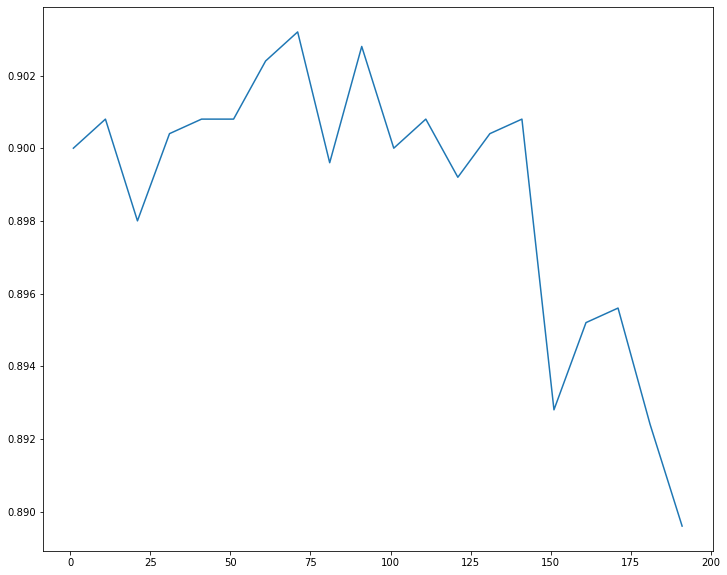

In [59]:
# Plot the tuning parameter curve
df_gs = pd.DataFrame(gs.cv_results_)

plt.figure(figsize=(12, 10))
plt.plot(df_gs["param_pc__n_components"], df_gs["mean_test_score"]);

## Part II: Transfer Learning with Clusters
Oftentimes, we'd actually like to _add_ dimensionality to our data to give our model more information. In this example, we will use clustering to use lattitude/longitude data effectively.

It's not shown in this example, but using clustering with transfer learning is more often used as dimensionality reduction similar to PCA. Use clusters as an x-variable to replace several other variables.

In [60]:
# Some data "cleaning"
# NOTE: This shouldn't be considered best, or even good, practice.
# This is merely to get the data into a workable shape so we don't
# spend our lesson cleaning missing and categorical columns.
mel = pd.read_csv("../data/melbourne.csv")
keepvars = [
    "Price", "Rooms", "Bedroom2", "Bathroom",
    "Car", "Landsize", "Lattitude", "Longtitude"
]
mel = mel[keepvars].dropna()
mel.columns = ["price", "rooms", "bed", "bath", "car", "land", "lat", "long"]
mel = mel.loc[mel["price"] < np.quantile(mel["price"], 0.99), :]
mel.head()

,price,rooms,bed,bath,car,land,lat,long
1,1480000.0,2,2.0,1.0,1.0,202.0,-37.7996,144.9984
2,1035000.0,2,2.0,1.0,0.0,156.0,-37.8079,144.9934
4,1465000.0,3,3.0,2.0,0.0,134.0,-37.8093,144.9944
5,850000.0,3,3.0,2.0,1.0,94.0,-37.7969,144.9969
6,1600000.0,4,3.0,1.0,2.0,120.0,-37.8072,144.9941


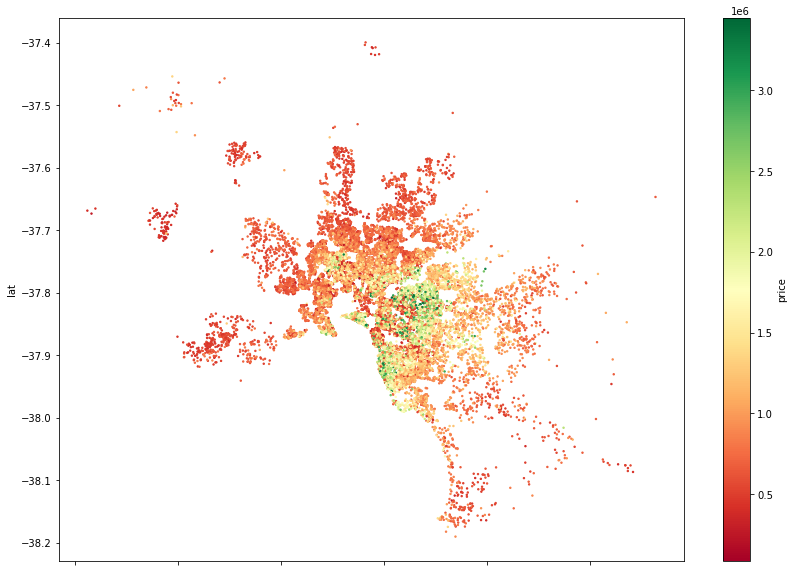

In [61]:
# Where are the highly prices houses?
mel.plot(kind="scatter", x="long", y="lat", c="price",
         cmap="RdYlGn", figsize=(14, 10), s=2);

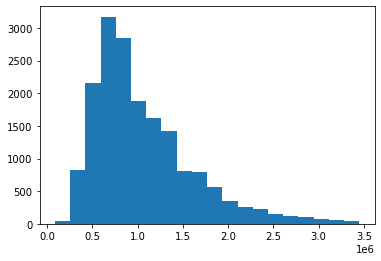

In [62]:
# Histogram of house prices - skew?
plt.hist(mel["price"], bins=20);

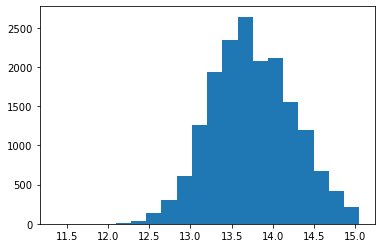

In [64]:
# Check histogram of log-price
plt.hist(y, bins=20);

In [63]:
# Let's winnow our data down to only these quantitative variables.
xvars = ["rooms", "bed", "bath", "car", "land"]
X = mel.copy()[xvars]

# House prices are skew - so let's do log regression.
y = np.log(mel.copy()["price"])

In [65]:
# Let's do a train-test-split
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.5
)

In [66]:
# Carry out a linear regression
model = LinearRegression()
model.fit(X_train, y_train);

In [67]:
# How'd it do?
model.score(X_test, y_test)

0.27028792076632213

### The regular log-model performed kinda badly...
But as we saw in our map, home prices are not distributed uniformly about Melbourne. What if we clustered by lat/long, and used those clusters in our model?

In [68]:
# Let's scoop lat/long up in a matrix so we can use them easily
location_data = mel[["long", "lat"]]
location_data.head()

,long,lat
1,144.9984,-37.7996
2,144.9934,-37.8079
4,144.9944,-37.8093
5,144.9969,-37.7969
6,144.9941,-37.8072


In [69]:
# Let's cluster our observations by lat/long
km = KMeans(n_clusters=20)
km.fit(location_data)

KMeans(n_clusters=20)

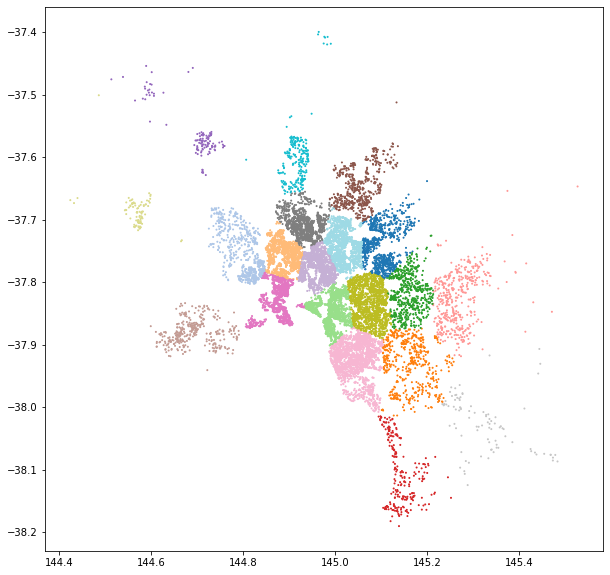

In [70]:
# What do these clusters look like visually?
plt.figure(figsize=(10, 10))
plt.scatter(mel.long, mel.lat, c=km.labels_, s=1, cmap="tab20");

In [71]:
# Neat! Now let's append these clusters back onto X
X.loc[:, "cluster"] = km.predict(location_data)
X = pd.get_dummies(columns=["cluster"], data=X)
X.head()

,rooms,bed,bath,car,land,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,...,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17,cluster_18,cluster_19
1,2,2.0,1.0,1.0,202.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2.0,1.0,0.0,156.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,3.0,2.0,0.0,134.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,3,3.0,2.0,1.0,94.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4,3.0,1.0,2.0,120.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
# Train-test-split again
X_train, X_test, y_train, y_test = train_test_split(
    X.copy(), y.copy(), random_state=42, test_size=0.5
)

In [73]:
# How'd we do now?
model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.5485594908226599

### Issue #1: How do we tune $k$?
Two choices:
1. Bottle all the above into a function and iterate, finding $k$ that gives the best testing error.
2. Force this into a gridsearchable class.
    * We can't use `GridSearchCV` now because clusterers aren't _transformers_.
    * In order to fix this, we'll need some OOP skills outside the scope of today's lesson. In short, you can subclass a scikit-learn mixin and create your own class that acts like a scikit-learn transformer. I wrote a blog post about how to do this [here](https://towardsdatascience.com/building-a-custom-model-in-scikit-learn-b0da965a1299)!

In [74]:
# All this wrapped up!
def transfer_tune(X, y, k):
    location_data = mel[["long", "lat"]]
    km = KMeans(n_clusters=k)
    km.fit(location_data)  # First we learn how to cluster
    X.loc[:, "cluster"] = km.predict(location_data) 
    X_dummy = pd.get_dummies(columns=["cluster"], data=X)
    X_train, X_test, y_train, y_test = train_test_split(
        X_dummy.copy(), y.copy(), random_state=42, test_size=0.5
    )
    model = LinearRegression()
    model.fit(X_train, y_train) # Then we apply it in modeling prices
    r2 = model.score(X_test, y_test)
    print(f"{k} : {r2}")

In [75]:
for k in range(2, 103, 5):
    transfer_tune(X, y, k)

2 : 0.5486191021181672
7 : 0.569406796644994
12 : 0.5671295239854082
17 : 0.5602553486122188
22 : 0.5661890931103447
27 : 0.5755549335864276
32 : 0.5848823396429245
37 : 0.5904206010637474
42 : 0.5948619366754646
47 : 0.6015062745964614
52 : 0.6034390232850918
57 : 0.6021312860014846
62 : 0.6093270352221053
67 : 0.6095324981362834
72 : 0.6104915496281389
77 : 0.6145698567275598
82 : 0.6132802892615388
87 : 0.615101366270481
92 : 0.6218651805356623
97 : 0.6192104893950506
102 : 0.6175114799535362


### Issue #2: The Train-Test-Split Dilemma
If you have many clusters, it is possible that your test data will have some clusters not represented. Using `pd.get_dummies()` won't help you here - it won't make columns for unrepresented categories.

**Example:**
Suppose you do 10-means clustering on your training data. Your training data now has labels 1 through 10. There's no guarantee that every cluster would be represented in your test data. Maybe no testing data points are put into cluster 5. When you use `pd.get_dummies()` on your testing data, it won't make a `cluster_5` column, and scikit-learn will complain about dimension mismatches (since you have one fewer column in `X_test` now).

In a production setting, you might prefer to use the `OneHotEncoder` scikit-learn class:

In [33]:
D_train = pd.DataFrame({"cluster": ['A', 'B', 'C', 'D', 'E']})
D_test = pd.DataFrame({"cluster": ['A', 'B', 'C', 'E']})

In [34]:
pd.get_dummies(columns=["cluster"], data=D_train)

,cluster_A,cluster_B,cluster_C,cluster_D,cluster_E
0,1,0,0,0,0
1,0,1,0,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,0,1


In [35]:
pd.get_dummies(columns=["cluster"], data=D_test)

,cluster_A,cluster_B,cluster_C,cluster_E
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1


In [76]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
km.labels_

array([ 0,  0,  0, ..., 16, 16, 16])

In [38]:
oh = OneHotEncoder(categories="auto", sparse=False)
oh.fit(km.labels_.reshape(-1, 1))

OneHotEncoder(sparse=False)

In [39]:
dummy_matrix = oh.transform(km.labels_.reshape(-1, 1))

In [40]:
dummy_matrix

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
dummy_matrix.shape

(17501, 20)

In [58]:
ohe = OneHotEncoder(categories='auto', sparse=False)
ohe.fit(D_train[['cluster']])
ohe.transform(D_train)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [59]:
ohe.transform(D_test)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])